In [1]:
import pandas as pd
import numpy as np

## Read data

In [4]:
calendar = pd.read_feather('/Users/Panot/Desktop/m5/data/calendar.feather')
sales = pd.read_feather('/Users/Panot/Desktop/m5/data/sales_train_validation.feather')
price = pd.read_feather('/Users/Panot/Desktop/m5/data/sell_prices.feather')

In [7]:
calendar.shape

(1969, 14)

In [12]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


Sales is still in wide format

In [8]:
sales.shape

(30490, 1919)

In [11]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [9]:
price.shape

(6841121, 4)

In [21]:
sales_long = pd.melt(sales, 
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='date',
                     value_name='sales')

In [22]:
sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


## Aggregation to nation level

In [26]:
sales_nation = sales_long.groupby(['cat_id', 'date']).agg({'sales':'sum'}).reset_index()

In [29]:
sales_nation =  sales_nation.merge(calendar, left_on = 'date', right_on = 'd', how = 'left')

In [33]:
sales_nation.sort_values(['cat_id', 'wm_yr_wk'], inplace=True)

In [34]:
sales_nation.head()

,cat_id,date_x,sales,date_y,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS,d_1,23178.0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1025,FOODS,d_2,22758.0,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
1136,FOODS,d_3,17174.0,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
1247,FOODS,d_4,18878.0,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
1358,FOODS,d_5,14603.0,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [57]:
sales_nation['date_index'] = sales_nation['d'].replace('d_', '', regex=True).astype('int')

In [58]:
sales_nation.head()

,cat_id,date_x,sales,date_y,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,date_index
0,FOODS,d_1,23178.0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0,1
1025,FOODS,d_2,22758.0,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0,2
1136,FOODS,d_3,17174.0,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0,3
1247,FOODS,d_4,18878.0,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0,4
1358,FOODS,d_5,14603.0,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1,5


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

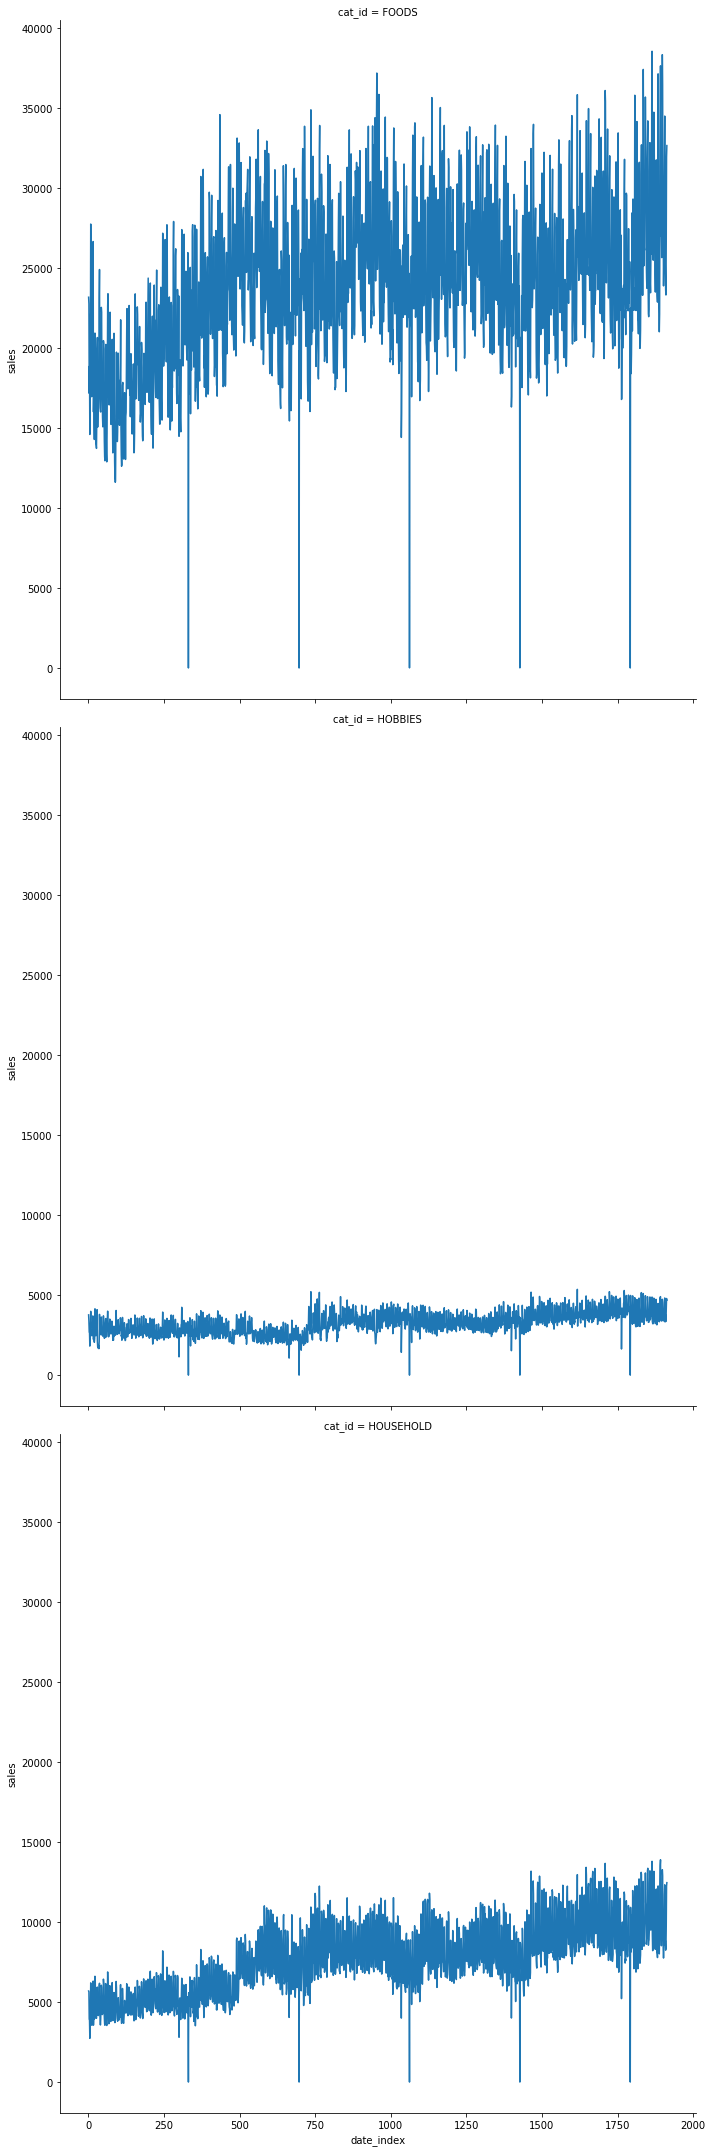

In [61]:
grid = sns.FacetGrid(sales_nation, row='cat_id', height=10)

grid.map(sns.lineplot,
         'date_index',
         'sales')